In [2]:
import tensorflow as tf
from tensorflow import keras
import load_data
from load_data import split_data
import warnings
import numpy as np
import pandas as pd
import const
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip drive/MyDrive/img.zip

Archive:  drive/MyDrive/img.zip
  inflating: np_arrays/images_and_labels.npy  


In [5]:
data = np.load('np_arrays/images_and_labels.npy', allow_pickle=True)
image_qualities=np.load('drive/MyDrive/image_quality.npy', allow_pickle=True)
names=np.load('drive/MyDrive/name.npy')

In [6]:
pd_data=pd.DataFrame(data, columns=['Images', 'Labels', 'Image_Quality'])

In [7]:
images=data[:, 0]
labels=data[:, 1]
image_quality=data[:, 2]


In [8]:
import bird_info
bird_info.visualise_images(images=images, labels=labels)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
labels_value, labels_counts = np.unique(labels, return_counts=True)
image_quality_values, image_quality_counts = np.unique(labels, return_counts=True)

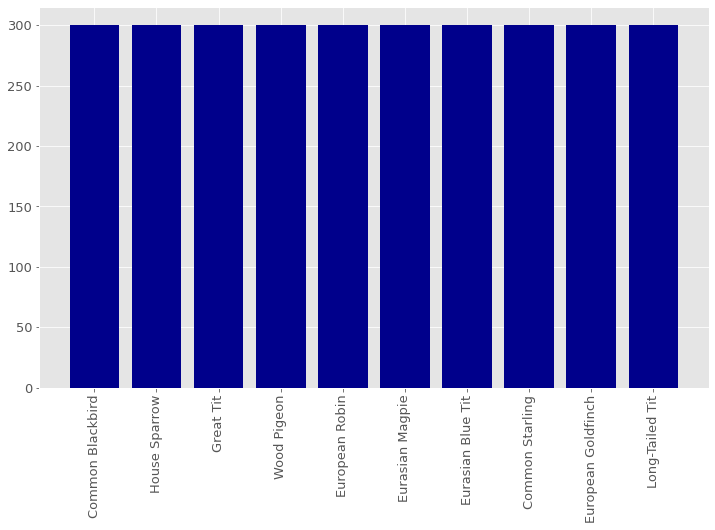

In [10]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,7))
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

plt.bar(np.arange(10), labels_counts, align='center', color='darkblue')
plt.xticks(np.arange(10), const.COMMON_NAMES, rotation=90)
plt.yticks=labels_counts
plt.show()

In [11]:
aggs=pd_data.groupby(['Labels', 'Image_Quality'])['Labels'].count().unstack()
aggs.columns=['Excellent','Good','Average','Poor','Very Poor']
aggs.index=const.COMMON_NAMES
aggs

,Excellent,Good,Average,Poor,Very Poor
Common Blackbird,24,90,107,50,29
House Sparrow,17,83,139,38,23
Great Tit,19,116,92,46,27
Wood Pigeon,13,90,147,28,22
European Robin,37,141,92,24,6
Eurasian Magpie,6,119,141,24,10
Eurasian Blue Tit,11,136,125,26,2
Common Starling,4,79,154,51,12
European Goldfinch,1,109,144,39,7
Long-Tailed Tit,5,71,169,45,10


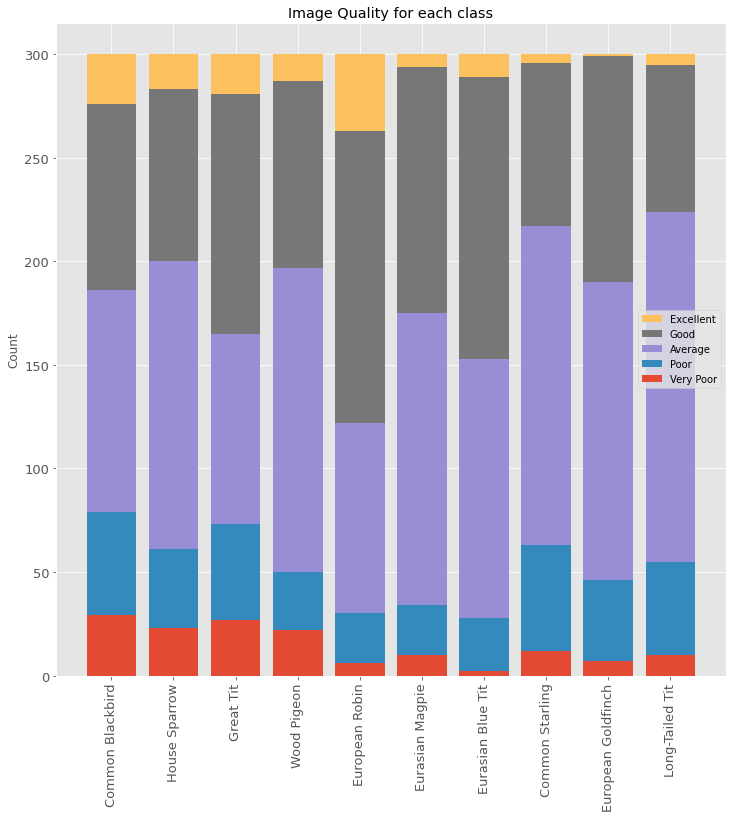

In [12]:
fig, ax = plt.subplots(figsize=(12,12))

image_quality_l=aggs.columns.tolist()
labels_l=aggs.index.tolist()

y1=aggs['Excellent']
y2=aggs['Good']
y3=aggs['Average']
y4=aggs['Poor']
y5=aggs['Very Poor']

very_poor=ax.bar(labels_l, y5, label=image_quality_l[4])
poor=ax.bar(labels_l, y4, bottom=y5, label=image_quality_l[3])
average=ax.bar(labels_l, y3, bottom=y4+y5, label=image_quality_l[2])
good=ax.bar(labels_l, y2, bottom=y3+y4+y5, label=image_quality_l[1])
excellent=ax.bar(labels_l, y1, bottom=y2+y3+y4+y5, label=image_quality_l[0])

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

ax.set_xticklabels(labels_l, rotation=90)
ax.set_ylabel('Count')
ax.set_title('Image Quality for each class')
ax.legend(handles=[excellent, good, average, poor, very_poor], loc=0)

plt.show()


In [13]:
pd_data_n=pd_data[pd_data['Image_Quality']<=2]

In [14]:
resize_images=[]
for i in pd_data_n.index:
    resize_images.append(cv2.resize(images[i], (256,256)))

KeyError: ignored

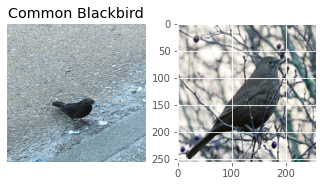

In [16]:
# bird_info.visualise_images(images=resize_images, labels=labels)

In [17]:
l=pd_data_n['Labels']

In [18]:
# import models
# from models import alex_net

In [19]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout, Rescaling

def alexNet():
    #Instantiation
    AlexNet = keras.Sequential()

    AlexNet.add(layers.RandomFlip("horizontal"))
    AlexNet.add(layers.RandomRotation(0.1))
    
    AlexNet.add(layers.Rescaling(1./255))

    #1st Convolutional Layer - 96 filters instead of two parllel 48 filters
    AlexNet.add(Conv2D(filters=96, input_shape=(256, 256,3), kernel_size=(3,3), strides=(4,4), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #2nd Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #3rd Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #4th Convolutional Layer
    AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))

    #5th Convolutional Layer
    AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

    #Passing it to a Fully Connected layer
    AlexNet.add(Flatten())
    # 1st Fully Connected Layer
    AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    AlexNet.add(Dropout(0.4))

    #2nd Fully Connected Layer
    AlexNet.add(Dense(4096))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #3rd Fully Connected Layer
    AlexNet.add(Dense(1000))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('relu'))
    #Add Dropout
    AlexNet.add(Dropout(0.4))

    #Output Layer
    AlexNet.add(Dense(10))
    AlexNet.add(BatchNormalization())
    AlexNet.add(Activation('softmax'))
    
    return AlexNet


In [20]:
m = alexNet()

In [21]:
len(resize_images)

1171

In [22]:
m.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
 


In [23]:
l=pd_data_n['Labels']
l=np.array(l)

In [59]:
X_train, X_test, Y_train, Y_test=train_test_split(resize_images, l,test_size=0.2, random_state=133)

In [60]:
X_train=np.array(X_train).astype('float32')
Y_train=np.array(Y_train).astype('float32')
X_test=np.array(X_test).astype('float32')
Y_test=np.array(Y_test).astype('float32')

In [61]:
Y_train = keras.utils.to_categorical(Y_train, num_classes=10)
Y_test = keras.utils.to_categorical(Y_test, num_classes=10)

In [62]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Ytrain))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [63]:
# Y_train=Y_train.reshape((24000,1))

In [64]:
Y_train.shape

(936, 10)

In [66]:
h=m.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, verbose=1)

Epoch 1/500
30/30 [==============================] - 1s 49ms/step - loss: 0.2301 - accuracy: 0.9519 - val_loss: 1.8214 - val_accuracy: 0.4681
Epoch 2/500
30/30 [==============================] - 1s 47ms/step - loss: 0.2394 - accuracy: 0.9455 - val_loss: 1.9895 - val_accuracy: 0.4468
Epoch 3/500
30/30 [==============================] - 1s 46ms/step - loss: 0.2266 - accuracy: 0.9423 - val_loss: 1.8272 - val_accuracy: 0.4596
Epoch 4/500
30/30 [==============================] - 1s 46ms/step - loss: 0.2120 - accuracy: 0.9519 - val_loss: 1.9068 - val_accuracy: 0.4723
Epoch 5/500
30/30 [==============================] - 1s 46ms/step - loss: 0.2036 - accuracy: 0.9541 - val_loss: 1.9398 - val_accuracy: 0.4468
Epoch 6/500
30/30 [==============================] - 1s 46ms/step - loss: 0.1946 - accuracy: 0.9573 - val_loss: 1.8357 - val_accuracy: 0.4851
Epoch 7/500
30/30 [==============================] - 1s 46ms/step - loss: 0.2092 - accuracy: 0.9498 - val_loss: 1.8409 - val_accuracy: 0.4468
Epoch 

KeyboardInterrupt: ignored